## Import libraries và Setup FiinQuant

In [53]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from backtesting import Backtest, Strategy
from FiinQuantX import FiinSession

In [54]:
# Login FiinQuant
def setup_fiinquant_client():
    """Khởi tạo FiinQuantX client"""
    username = 'DSTC_19@fiinquant.vn'
    password = 'Fiinquant0606'
    client = FiinSession(
        username=username,
        password=password,
    ).login()
    return client

print("Setup imported successfully!")

Setup imported successfully!


## Get data & Calculate technical indicators

In [55]:
def fetch_stock_data(client, tickers, from_date, to_date):
    """
    Lấy dữ liệu cổ phiếu và tính các chỉ báo kỹ thuật
    
    Parameters:
    -----------
    client : FiinSession
        FiinQuantX client đã login
    tickers : list
        Danh sách mã cổ phiếu
    from_date : str
        Ngày bắt đầu (format: 'YYYY-MM-DD')
    to_date : str
        Ngày kết thúc (format: 'YYYY-MM-DD')
    
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa dữ liệu giá và các chỉ báo kỹ thuật
    """
    print(f"Fetching data for {tickers} from {from_date} to {to_date}...")
    
    # Lấy dữ liệu giá
    df = client.Fetch_Trading_Data(
        realtime=False,
        tickers=tickers,    
        fields=['open', 'high', 'low', 'close', 'volume'],
        adjusted=True,
        by='1d', 
        from_date=from_date,
        to_date=to_date,
    ).get_data()
    
    # Tính các chỉ báo kỹ thuật
    print("Computing technical indicators...")
    fi = client.FiinIndicator()
    
    # RSI
    df['rsi'] = fi.rsi(df['close'], window=14)
    
    print(f"Data fetched successfully! Shape: {df.shape}")
    return df

# Test function
print("Data fetching functions defined successfully!")

Data fetching functions defined successfully!


## Signal generation function (VSA/Wyckoff)

In [56]:
def generate_trade_signals(df: pd.DataFrame,
                           min_true: int = 1,
                           rsi_buy_th: float = 35,
                           rsi_sell_th: float = 65,
                           # mfi_buy_th: float = 20,      # giữ tham số cho tương thích
                           # mfi_sell_th: float = 80,     # giữ tham số cho tương thích
                           tplus2_bars: int = 2,
                           vol_lo: float = 0.85, vol_hi: float = 1.2,
                           spr_lo: float = 0.8, spr_hi: float = 1.2,
                           spr_lookback: int = 20) -> pd.DataFrame:
    """
    Tín hiệu Wyckoff/VSA + RSI (RSI cộng điểm mềm).
    Thay đổi theo yêu cầu: tín hiệu đầu tiên bắt buộc là BUY; sau đó có thể BUY/SELL nhiều lần.
    SELL vẫn phải cách lần BUY gần nhất ít nhất tplus2_bars phiên.
    Trả về cột: buy_score, sell_score, signal (1,0,-1).
    """
    out = df.sort_values(["ticker", "timestamp"]).copy()

    def _per_ticker(g: pd.DataFrame) -> pd.DataFrame:
        g = g.copy()

        # ====== VSA features ======
        prev_close = g["close"].shift(1)
        g["_bar"] = np.where(g["close"] > prev_close, "up",
                      np.where(g["close"] < prev_close, "down", "flat"))

        sma20_vol = g["volume"].rolling(20, min_periods=1).mean()
        vratio = g["volume"] / sma20_vol.replace(0, np.nan)
        g["_vol"] = np.select([vratio < vol_lo, vratio <= vol_hi, vratio > vol_hi],
                              ["low","medium","high"], default=np.nan)

        spread = (g["high"] - g["low"]).clip(lower=0)
        # spr_ref = (g["open"] - g["close"]).clip(lower=0)
        spr_ref = spread.rolling(spr_lookback, min_periods=1).mean()
        # sratio = spr_ref / spread.replace(0, np.nan)
        sratio = spread / spr_ref.replace(0, np.nan)
        g["_spr"] = np.select([sratio < spr_lo, sratio <= spr_hi, sratio > spr_hi],
                              ["low","medium","high"], default=np.nan)

        q1 = g["low"] + (g["high"] - g["low"]) / 3.0
        q2 = g["low"] + 2.0 * (g["high"] - g["low"]) / 3.0
        g["_cthird"] = np.select([g["close"] < q1, g["close"] < q2],
                                 ["bottom","middle"], default="top")

        # ====== Patterns (SOW/SOS từ slide) ======
        weakness_a = ((g["_bar"]=="down")&(g["_vol"]=="high")&
                      (g["_spr"].isin(["low","medium"]))&
                      (g["_cthird"].isin(["middle","bottom"])))
        no_demand = ((g["_bar"]=="up")&(g["_vol"]=="low")&
                     (g["_spr"].isin(["low","medium"]))&
                     (g["_cthird"].isin(["middle","top"])))
        upthrust = ((g["_bar"]=="up")&(g["_spr"]=="high")&
                    (g["_cthird"]=="bottom")&(g["_vol"].isin(["medium","high"])))
        buying_climax = ((g["_bar"]=="up")&(g["_spr"]=="high")&
                         (g["_vol"]=="high")&(g["_cthird"]=="middle"))

        power_a = ((g["_bar"]=="up")&(g["_spr"]=="high")&
                   (g["_vol"].isin(["medium","high"]))&(g["_cthird"]=="top"))
        force_b = ((g["_bar"]=="down")&(g["_spr"].isin(["medium","high"]))&
                   (g["_vol"]=="high")&(g["_cthird"]=="bottom"))
        reverse_upthrust = ((g["_spr"]=="high")&(g["_vol"]=="high")&(g["_cthird"]=="top"))
        selling_climax = ((g["_bar"]=="down")&(g["_spr"]=="high")&
                          (g["_vol"]=="high")&(g["_cthird"]=="middle"))

        sos = pd.concat([power_a, force_b, reverse_upthrust, selling_climax], axis=1)
        sow = pd.concat([weakness_a, no_demand, upthrust, buying_climax], axis=1)

        buy_score = sos.sum(axis=1).astype(int)
        sell_score = sow.sum(axis=1).astype(int)

        if "rsi" in g.columns:
            buy_score = buy_score + (g["rsi"] < rsi_buy_th).fillna(False).astype(int)
            sell_score = sell_score + (g["rsi"] > rsi_sell_th).fillna(False).astype(int)

        g["buy_score"] = buy_score
        g["sell_score"] = sell_score

        buy_raw  = (g["buy_score"]  >= min_true)
        sell_raw = (g["sell_score"] >= min_true)

        # Loại bỏ xung đột cùng phiên
        conflict = buy_raw & sell_raw
        buy_raw &= ~conflict
        sell_raw &= ~conflict

        # ====== State machine (sửa theo yêu cầu) ======
        sig = np.zeros(len(g), dtype=int)
        seen_first_buy = False
        last_buy_idx = None  # dùng để check T+2 cho SELL

        for i in range(len(g)):
            if not seen_first_buy:
                # Trước khi có BUY đầu tiên: chỉ chấp nhận BUY
                if buy_raw.iloc[i]:
                    sig[i] = 1
                    seen_first_buy = True
                    last_buy_idx = i
                # SELL (nếu có) sẽ bị bỏ qua
                continue

            # Sau BUY đầu tiên: cho phép BUY hoặc SELL nhiều lần
            placed = False
            if buy_raw.iloc[i]:
                sig[i] = 1
                last_buy_idx = i  # reset mốc T+2 theo lần buy gần nhất
                placed = True

            # SELL hợp lệ nếu đã qua T+2 kể từ lần BUY gần nhất
            if (not placed) and sell_raw.iloc[i]:
                if (last_buy_idx is not None) and ((i - last_buy_idx) >= tplus2_bars):
                    sig[i] = -1
                    # không thay đổi last_buy_idx để cho phép SELL nhiều lần dựa trên cùng mốc BUY

        g["signal"] = sig
        return g

    out = out.groupby("ticker", group_keys=False).apply(_per_ticker)
    return out

print("Signal generation function defined successfully!")

Signal generation function defined successfully!


## Portfolio optimization function

In [57]:
def optimize_portfolio_weights(
    df: pd.DataFrame,
    tickers: list,
    capital_vnd: float = 1_000_000_000,          # 1 tỷ
    lookback_days: int = 180,                    # dùng 180 phiên gần nhất
    target_return_range=(0.20, 0.25),            # mục tiêu lợi nhuận năm 20–25%
    bank_rate_ann: float = 0.10,                 # lãi suất tham chiếu ~10%/năm
    w_lower: float = 0.05,                       # mỗi mã ≥ 5% danh mục
    w_upper: float = 0.50,                       # (tùy chọn) mỗi mã ≤ 50% để tránh tập trung
    board_lot: int = 100                         # lô 100 cổ (VN)
):
    """
    Trả về DataFrame gồm weight cho mỗi mã + thông tin kỳ vọng danh mục.
    Bài toán: Min w^T Σ w
    Ràng buộc:
        - sum(w) = 1, w_lower ≤ w ≤ w_upper
        - (r_20d . w) ≥ 0  và (r_60d . w) ≥ 0  (trung bình ngắn hạn dương)
        - (mu_ann . w) ∈ [target_return_range]
        - (mu_lookback_ann . w) ≥ bank_rate_ann (trung hạn > lãi NH)
    """
    print("Optimizing portfolio weights...")
    
    # ----- 1) Chuẩn bị ma trận giá/returns -----
    px = (
        df[df["ticker"].isin(tickers)]
        .pivot(index="timestamp", columns="ticker", values="close")
        .sort_index()
    ).dropna(how="any", axis=0)  # đồng bộ ngày giữa các mã

    if len(px) < max(lookback_days, 65):  # cần đủ dữ liệu cho r_60d
        raise ValueError("Chưa đủ dữ liệu để tối ưu (thiếu số phiên).")

    # Lấy cửa sổ lookback
    px_lb = px.tail(lookback_days)
    ret = px_lb.pct_change().dropna()

    # Annualize theo lãi kép từ mean geometric
    n = ret.shape[0]
    geom = (1.0 + ret).prod(axis=0) ** (252.0 / n) - 1.0          # mu_ann cho từng mã
    mu_ann = geom.values                                           # (n_asset,)

    # Trung bình 20/60 ngày (không annualize – chỉ yêu cầu dương)
    r20 = ret.tail(20).mean().values
    r60 = ret.tail(60).mean().values

    # Trung bình lookback annualized (so với lãi NH)
    mu_lb_ann = (1.0 + ret).prod(axis=0) ** (252.0 / n) - 1.0
    mu_lb_ann = mu_lb_ann.values

    # Hiệp phương sai annualized
    Sigma_ann = (ret.cov() * 252.0).values
    tickers_order = list(px_lb.columns)
    m = len(tickers_order)

    # ----- 2) Thiết lập QP -----
    w = cp.Variable(m)

    cons = [
        cp.sum(w) == 1,
        w >= w_lower,
        w <= w_upper,
        r20 @ w >= 0,                # điều kiện ngắn hạn dương
        r60 @ w >= 0,
        mu_lb_ann @ w >= bank_rate_ann,   # trung hạn > lãi NH
        mu_ann @ w >= target_return_range[0],
        mu_ann @ w <= target_return_range[1],
    ]

    objective = cp.Minimize(cp.quad_form(w, Sigma_ann))
    prob = cp.Problem(objective, cons)

    try:
        prob.solve(solver=cp.SCS, verbose=False)  # hoặc OSQP/ECOS nếu bạn có cài
    except Exception:
        prob.solve(verbose=False)

    # Nếu không khả thi, nới ràng buộc phía trên về chỉ "≥ lower"
    if prob.status not in ("optimal", "optimal_inaccurate"):
        print("Relaxing upper bound constraint...")
        cons = [
            cp.sum(w) == 1,
            w >= w_lower,
            w <= w_upper,
            r20 @ w >= 0,
            r60 @ w >= 0,
            mu_lb_ann @ w >= bank_rate_ann,
            mu_ann @ w >= target_return_range[0],
        ]
        prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma_ann)), cons)
        prob.solve(solver=cp.SCS, verbose=False)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError("Bài toán tối ưu không khả thi với các ràng buộc hiện tại.")

    w_opt = np.clip(np.array(w.value).reshape(-1), 0, None)
    # xử lý trôi số -> chuẩn hóa lại để tổng đúng 1
    if w_opt.sum() > 0:
        w_opt = w_opt / w_opt.sum()

    # ----- 3) Tính thông tin kỳ vọng danh mục -----
    exp_ret_ann = float(mu_ann @ w_opt)
    vol_ann = float(np.sqrt(w_opt @ Sigma_ann @ w_opt))

    last_px = px_lb.iloc[-1].values
    capital_alloc = w_opt * capital_vnd
    # lượng cổ phiếu ước tính (làm tròn theo lô 100)
    shares_est = np.floor(capital_alloc / last_px / board_lot) * board_lot

    out = pd.DataFrame({
        "ticker": tickers_order,
        "weight": w_opt.round(4),
        "capital_alloc": capital_alloc.round(0).astype("int64"),
        "last_price": last_px.round(2),
        "shares_est": shares_est.astype("int64"),
    }).sort_values("weight", ascending=False).reset_index(drop=True)

    summary = {
        "expected_portfolio_return_ann": round(exp_ret_ann, 4),
        "expected_portfolio_vol_ann": round(vol_ann, 4),
        "status": prob.status
    }
    
    print("Portfolio optimization completed!")
    return out, summary

print("Portfolio optimization function defined successfully!")

Portfolio optimization function defined successfully!


## Backtesting functions

In [58]:
# Signal Strategy for backtesting
class SignalStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        sig = int(self.data.Signal[-1])

        if sig == 1 and not self.position:
            price = float(self.data.Close[-1])
            # Chừa biên cho phí/thuế (ví dụ ~0.1%)
            budget = self.equity * 0.999
            size = int(budget // price)   # số cổ phiếu nguyên
            if size > 0:
                self.buy(size=size)

        elif sig == -1 and self.position.is_long:
            self.position.close()

In [59]:
def _prep_data_one_ticker(df, ticker):
    d = df[df["ticker"] == ticker].sort_values("timestamp").copy()
    out = pd.DataFrame({
        "Open":   d["open"].values,
        "High":   d["high"].values,
        "Low":    d["low"].values,
        "Close":  d["close"].values,
        "Volume": d["volume"].fillna(0).values,
        "Signal": d["signal"].fillna(0).values.astype(int),
    }, index=pd.to_datetime(d["timestamp"].values))
    return out

def run_single_backtest(df, ticker, cash, commission=0.001):
    data = _prep_data_one_ticker(df, ticker)
    bt = Backtest(
        data,
        SignalStrategy,
        cash=cash,
        commission=commission,
        exclusive_orders=True,
        trade_on_close=False,
        hedging=False,
    )
    stats = bt.run()
    equity_curve = stats["_equity_curve"][["Equity"]].rename(columns={"Equity": ticker})
    return stats, equity_curve


In [60]:
def backtest_portfolio(df, weights_df, capital_vnd=1_000_000_000, commission=0.001,
                       strategy=SignalStrategy, min_weight=1e-6):
    """
    - Bỏ qua các mã có weight ~ 0 để tránh cash=0.
    - Chuẩn hóa lại trọng số dương sao cho tổng = 1.
    """
    # Lọc các mã có trọng số dương
    wdf = weights_df.copy()
    wdf = wdf[wdf["weight"] > min_weight].reset_index(drop=True)

    if wdf.empty:
        raise ValueError("Tất cả trọng số đều bằng 0 sau khi lọc.")

    # Chuẩn hóa lại tổng trọng số dương = 1
    w_sum = float(wdf["weight"].sum())
    if not np.isclose(w_sum, 1.0):
        wdf["weight"] = wdf["weight"] / w_sum

    tickers = wdf["ticker"].tolist()
    weights = wdf.set_index("ticker")["weight"].to_dict()

    per_stats = {}
    curves = []

    for tk in tickers:
        # Bỏ qua mã không có dữ liệu trong df
        if tk not in df["ticker"].unique():
            continue

        # Chuẩn bị dữ liệu; nếu quá ngắn thì bỏ qua
        dprep = _prep_data_one_ticker(df, tk)
        if len(dprep) < 10 or dprep["Close"].isna().all():
            continue

        cash_i = capital_vnd * float(weights[tk])
        if cash_i <= 0:
            continue

        # Chạy backtest 1 mã
        bt = Backtest(dprep, strategy, cash=cash_i, commission=commission,
                      exclusive_orders=True, trade_on_close=False, hedging=False)
        stats_i = bt.run()
        curve_i = stats_i["_equity_curve"][["Equity"]].rename(columns={"Equity": tk})

        per_stats[tk] = {
            "Return[%]": float(stats_i["Return [%]"]),
            "Trades": int(stats_i["# Trades"]),
            "WinRate[%]": float(stats_i["Win Rate [%]"]),
            "MaxDD[%]": abs(float(stats_i["Max. Drawdown [%]"])),
        }
        curves.append(curve_i)

    if not curves:
        raise RuntimeError("Không có mã nào đủ điều kiện để backtest (sau khi lọc).")

    # Hợp nhất equity curve danh mục
    port_curve = pd.concat(curves, axis=1).sort_index().ffill().bfill()
    port_curve["Portfolio"] = port_curve.sum(axis=1)

    # Chỉ số danh mục
    equity = port_curve["Portfolio"]
    ret_total = equity.iloc[-1] / capital_vnd - 1.0
    max_dd_pct = (equity / equity.cummax() - 1.0).min() * -100.0

    total_trades = int(sum(s["Trades"] for s in per_stats.values()))
    total_wins_est = sum((s["WinRate[%]"]/100.0) * s["Trades"] for s in per_stats.values())
    winrate_port_pct = 0.0 if total_trades == 0 else (total_wins_est / total_trades) * 100.0

    summary = {
        "Portfolio Return [%]": round(ret_total * 100.0, 2),
        "Portfolio Max Drawdown [%]": round(max_dd_pct, 2),
        "Total Trades": total_trades,
        "Win Rate [%] (est.)": round(winrate_port_pct, 2),
    }
    per_stats_df = pd.DataFrame(per_stats).T[["Return[%]","Trades","WinRate[%]","MaxDD[%]"]].round(2)
    return summary, per_stats_df, port_curve
print("Backtesting functions defined successfully!")

Backtesting functions defined successfully!


## Visualization Functions

In [61]:
def plot_signals(df: pd.DataFrame, ticker: str, title: str = None):
    """
    Vẽ đường giá đóng cửa và đánh dấu mũi tên ở các điểm Buy/Sell.
    - df phải đã có cột 'signal' do generate_trade_signals tạo ra.
    """
    data = df[df["ticker"] == ticker].sort_values("timestamp").copy()
    if data.empty:
        raise ValueError(f"Không tìm thấy dữ liệu cho mã {ticker}")
    
    buys = data[data["signal"] == 1]
    sells = data[data["signal"] == -1]
    
    plt.figure(figsize=(12, 3.5))
    plt.plot(data["timestamp"], data["close"], label="Closing Price", linewidth=1.5)
    plt.scatter(buys["timestamp"], buys["close"], marker="^", s=30, color='green', label="Buy", alpha=0.8)
    plt.scatter(sells["timestamp"], sells["close"], marker="v", s=30, color='red', label="Sell", alpha=0.8)
    
    plt.title(title or f"Buy and Sell signals for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (VND)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [62]:
def plot_portfolio_vs_index(
    port_curve: pd.DataFrame,
    client,
    init_capital: float = 1_000_000_000,
    index_ticker: str = "VNINDEX",
    from_date: str = None,
    to_date: str = None,
):
    """
    So sánh hiệu suất danh mục (từ backtest_portfolio) với chỉ số (VNINDEX).
    - Tự fetch VNINDEX bằng client, lọc đúng ticker, ghép ngày, ffill để tránh rỗng.
    - Chuẩn hóa hiệu suất từ NGÀY GIAO CẮT ĐẦU TIÊN (first common date).
    """
    # 1) Lấy VNINDEX
    idx_df = client.Fetch_Trading_Data(
        realtime=False,
        tickers=[index_ticker],
        fields=["close"],
        adjusted=True,
        by="1d",
        from_date=from_date,
        to_date=to_date,
    ).get_data()

    # Bảo đảm chỉ còn VNINDEX và index thời gian sạch
    idx_df = idx_df[idx_df["ticker"] == index_ticker].copy()
    idx_df["timestamp"] = pd.to_datetime(idx_df["timestamp"])
    idx_series = (
        idx_df.sort_values("timestamp")
              .set_index("timestamp")["close"]
              .asfreq("B")                # lịch ngày làm việc
              .ffill()
    )

    # 2) Chuẩn bị danh mục
    port = port_curve.copy()
    # đảm bảo datetime index, không timezone
    port.index = pd.to_datetime(port.index)
    if "Portfolio" not in port.columns:
        raise ValueError("port_curve phải có cột 'Portfolio' (từ backtest_portfolio).")
    port_series = (
        port["Portfolio"]
        .asfreq("B")
        .ffill()
    )

    # 3) Cắt theo khoảng (nếu user truyền from/to) để chắc chắn giao cắt
    if from_date:
        port_series = port_series[port_series.index >= pd.to_datetime(from_date)]
        idx_series  = idx_series[idx_series.index >= pd.to_datetime(from_date)]
    if to_date:
        port_series = port_series[port_series.index <= pd.to_datetime(to_date)]
        idx_series  = idx_series[idx_series.index <= pd.to_datetime(to_date)]

    # 4) Giao cắt ngày chung & chuẩn hóa từ ngày chung đầu tiên
    common_idx = port_series.index.intersection(idx_series.index)
    if len(common_idx) == 0:
        raise ValueError("Không tìm thấy ngày chung giữa port_curve và VNINDEX. Kiểm tra from/to_date.")
    start = common_idx.min()
    port_common = port_series.loc[start:].copy()
    idx_common  = idx_series.loc[start:].copy()

    perf_port = port_common / init_capital - 1.0
    perf_idx  = idx_common / idx_common.iloc[0] - 1.0

    # Phần này để in số liệu
    final_port = perf_port.iloc[-1] * 100
    final_idx  = perf_idx.iloc[-1] * 100
    excess     = final_port - final_idx
    print(f"Hiệu suất danh mục: {final_port:.2f}%")
    print(f"Hiệu suất {index_ticker}: {final_idx:.2f}%")
    print(f"Outperformance: {excess:.2f}%")
    
    # 5) Ghép và vẽ (không dropna toàn bộ)
    perf = pd.concat([perf_port.rename("Portfolio"),
                      perf_idx.rename(index_ticker)], axis=1)
    perf = perf.ffill().dropna(how="all")  # nếu 1 bên vắng một số ngày → ffill

    plt.figure(figsize=(12, 6))
    plt.plot(perf.index, perf["Portfolio"] * 100, label="Portfolio", linewidth=2)
    plt.plot(perf.index, perf[index_ticker] * 100, label=index_ticker, alpha=0.9)
    plt.title(f"Portfolio performance vs {index_ticker} performance")
    plt.ylabel("Performance (%)")
    plt.xlabel("Time")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [63]:
def inspect_trades(df, ticker, cash=1_000_000_000, commission=0.001):
    """Kiểm tra chi tiết các giao dịch của 1 mã"""
    stats, _ = run_single_backtest(df, ticker, cash, commission)
    print(f"=== {ticker} Trade Details ===")
    print(stats['_trades'])        # các lệnh, PnL, %P/L
    print(f"\nExposure Time [%]: {stats['Exposure Time [%]']}")
    return stats


## Main function

In [64]:
def run_complete_analysis(client, tickers, year, capital_vnd=1_000_000_000):
    """
    Chạy phân tích hoàn chỉnh cho 1 năm và bộ mã cổ phiếu
    
    Parameters:
    -----------
    client : FiinSession
        FiinQuantX client đã login
    tickers : list
        Danh sách mã cổ phiếu
    year : int
        Năm phân tích (ví dụ: 2023)
    capital_vnd : float
        Vốn ban đầu (default: 1 tỷ VND)
    
    Returns:
    --------
    dict
        Dictionary chứa tất cả kết quả phân tích
    """
    print(f"\n{'='*60}")
    print(f"RUNNING COMPLETE ANALYSIS FOR {year}")
    print(f"Tickers: {tickers}")
    print(f"Capital: {capital_vnd:,.0f} VND")
    print(f"{'='*60}")
    
    # 1. Lấy dữ liệu
    from_date = f"{year}-01-01"
    to_date = f"{year}-12-31"
    
    df = fetch_stock_data(client, tickers, from_date, to_date)
    
    # 2. Tạo tín hiệu giao dịch
    print("\nGenerating trading signals...")
    df_with_signals = generate_trade_signals(df)
    
    # 3. Tối ưu hóa danh mục
    try:
        weights_df, portfolio_info = optimize_portfolio_weights(
            df=df_with_signals,
            tickers=tickers,
            capital_vnd=capital_vnd,
            target_return_range=(0.2, 0.25),
            lookback_days=config.get('lookback_days', 180),
            w_lower=config.get('w_lower', 0.05),
            w_upper=config.get('w_upper', 0.5),
            bank_rate_ann=0.1
        )
        print("\nPortfolio Optimization Results:")
        print(weights_df)
        print("\nPortfolio Info:")
        for k, v in portfolio_info.items():
            print(f"{k}: {v}")
            
    except Exception as e:
        print(f"Portfolio optimization failed: {e}")
        # Fallback to equal weights
        weights_df = pd.DataFrame({
            'ticker': tickers,
            'weight': [1/len(tickers)] * len(tickers),
            'capital_alloc': [capital_vnd/len(tickers)] * len(tickers),
            'last_price': [0] * len(tickers),
            'shares_est': [0] * len(tickers)
        })
        portfolio_info = {"status": "equal_weights_fallback"}
        print("Using equal weights as fallback")
    
    # 4. Backtest
    try:
        summary, per_ticker_stats, port_curve = backtest_portfolio(
            df=df_with_signals,
            weights_df=weights_df,
            capital_vnd=capital_vnd,
            commission=0.001
        )
        
        print("\n" + "="*40)
        print("PORTFOLIO BACKTEST RESULTS")
        print("="*40)
        for k, v in summary.items():
            print(f"{k}: {v}")
        
        print(f"\nPER-TICKER PERFORMANCE:")
        print(per_ticker_stats)
        
        # 5. Visualization
        print(f"\nGenerating visualizations...")
        
        # Plot signals for each ticker
        for ticker in tickers:
            if ticker in df_with_signals['ticker'].values:
                plot_signals(df_with_signals, ticker, f"{ticker} - {year} Trading Signals")
        
        # Plot portfolio vs index
        try:
            plot_portfolio_vs_index(
                port_curve=port_curve,
                client=client,
                init_capital=capital_vnd,
                index_ticker="VNINDEX",
                from_date=from_date,
                to_date=to_date
            )
        except Exception as e:
            print(f"Could not compare with VNINDEX: {e}")
        
    except Exception as e:
        print(f"Backtesting failed: {e}")
        summary = {"error": str(e)}
        per_ticker_stats = pd.DataFrame()
        port_curve = pd.DataFrame()
    
    # Return all results
    results = {
        'year': year,
        'tickers': tickers,
        'data': df_with_signals,
        'weights': weights_df,
        'portfolio_info': portfolio_info,
        'backtest_summary': summary,
        'per_ticker_stats': per_ticker_stats,
        'portfolio_curve': port_curve
    }
    
    return results

print("Main analysis function defined successfully!")

Main analysis function defined successfully!


In [65]:
# Initialize client (chỉ chạy 1 lần)
client = setup_fiinquant_client()
print("FiinQuantX client initialized!")

FiinQuantX client initialized!


## Config for different years

In [66]:
# Cấu hình cho các năm khác nhau
CONFIGS = {
    2021: {
        'tickers': ['IJC', 'TDC', 'PRE', 'VLC', 'FMC'], 
        'capital': 1_000_000_000,
        'description': 'Portfolio 2021'
    },
    2022: {
        'tickers': ['CTG', 'TNG', 'CSV', 'TDM', 'SJD'], 
        'capital': 1_000_000_000,
        'description': 'Portfolio 2022',
        'lookback_days' : 60,
    },
    2023: {
        'tickers': ['CTG', 'HDB', 'DRC','NT2', 'VPD'], 
        'capital': 1_000_000_000,
        'description': 'Portfolio 2023'
    }
}

# Display available configurations
print("Available Configurations:")
print("-" * 50)
for year, config in CONFIGS.items():
    print(f"{year}: {config['description']}")
    print(f"   Tickers: {config['tickers']}")
    print(f"   Capital: {config['capital']:,.0f} VND")
    print()

Available Configurations:
--------------------------------------------------
2021: Portfolio 2021
   Tickers: ['IJC', 'TDC', 'PRE', 'VLC', 'FMC']
   Capital: 1,000,000,000 VND

2022: Portfolio 2022
   Tickers: ['CTG', 'TNG', 'CSV', 'TDM', 'SJD']
   Capital: 1,000,000,000 VND

2023: Portfolio 2023
   Tickers: ['CTG', 'HDB', 'DRC', 'NT2', 'VPD']
   Capital: 1,000,000,000 VND



## Run analysis for specific year


RUNNING COMPLETE ANALYSIS FOR 2023
Tickers: ['CTG', 'HDB', 'DRC', 'NT2', 'VPD']
Capital: 1,000,000,000 VND
Fetching data for ['CTG', 'HDB', 'DRC', 'NT2', 'VPD'] from 2023-01-01 to 2023-12-31...
Fetching data, it may take a while. Please wait...
Computing technical indicators...
Data fetched successfully! Shape: (1245, 8)

Generating trading signals...
Optimizing portfolio weights...
Portfolio optimization completed!

Portfolio Optimization Results:
  ticker  weight  capital_alloc  last_price  shares_est
0    HDB  0.3288      328757235    16247.81       20200
1    CTG  0.2363      236288044    27100.00        8700
2    VPD  0.2180      217951430    20619.23       10500
3    DRC  0.1372      137178881    19078.81        7100
4    NT2  0.0798       79824411    22918.33        3400

Portfolio Info:
expected_portfolio_return_ann: 0.2
expected_portfolio_vol_ann: 0.153
status: optimal


Backtest.run:   0%|          | 0/248 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/248 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/248 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/248 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/248 [00:00<?, ?bar/s]


PORTFOLIO BACKTEST RESULTS
Portfolio Return [%]: 15.57
Portfolio Max Drawdown [%]: 5.62
Total Trades: 51
Win Rate [%] (est.): 60.78

PER-TICKER PERFORMANCE:
     Return[%]  Trades  WinRate[%]  MaxDD[%]
HDB      30.22     7.0      100.00     13.57
CTG      -8.36    11.0       45.45     21.21
VPD      20.45    14.0       64.29     12.20
DRC      22.93    10.0       60.00     12.42
NT2       0.06     9.0       44.44     13.46

Generating visualizations...


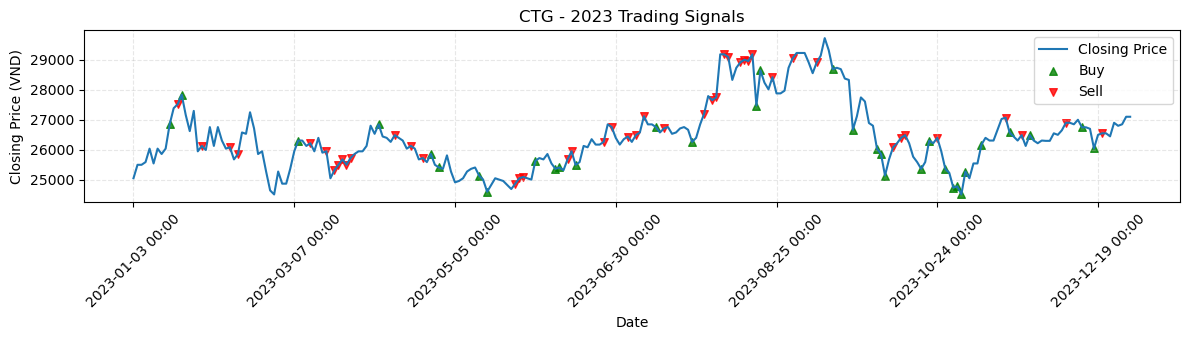

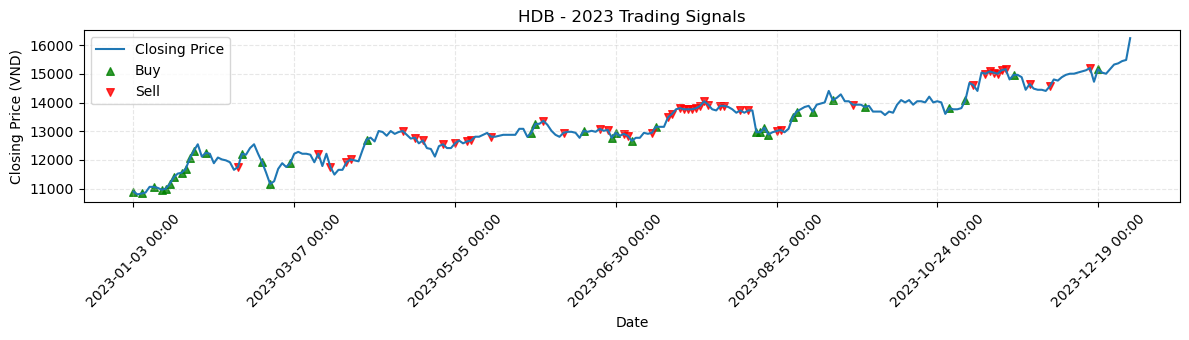

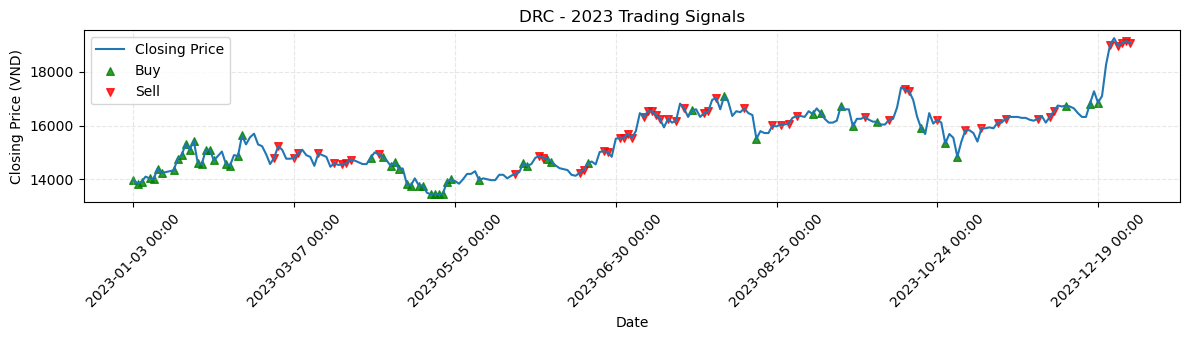

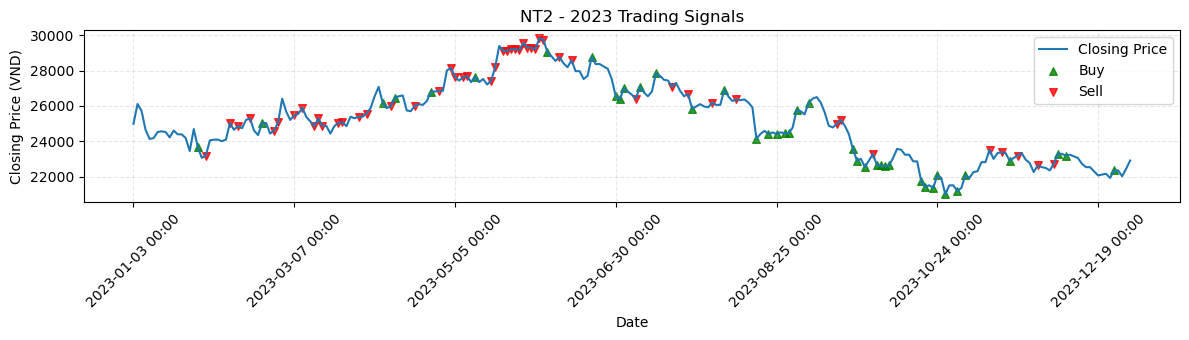

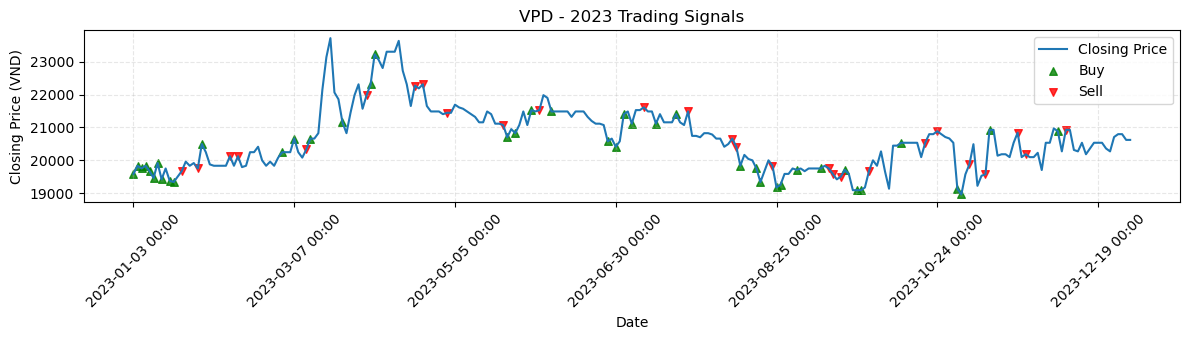

Fetching data, it may take a while. Please wait...
Hiệu suất danh mục: 15.57%
Hiệu suất VNINDEX: 8.24%
Outperformance: 7.33%


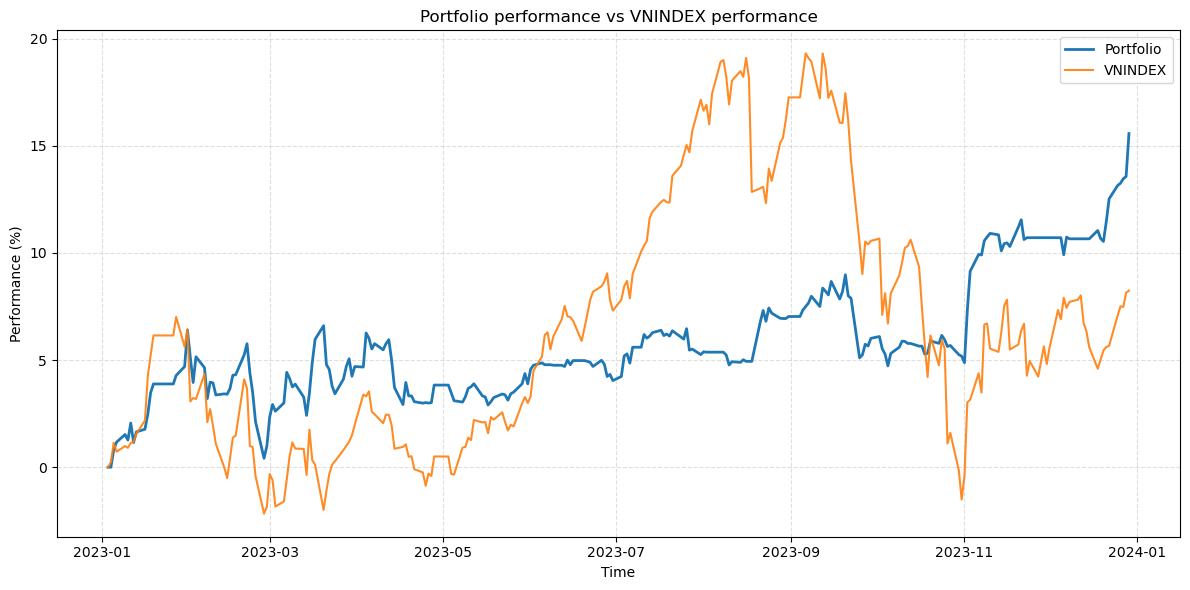


Analysis completed for 2023!
Results saved in 'results' variable


In [72]:
# CHỌN NĂM MUỐN PHÂN TÍCH
YEAR_TO_ANALYZE = 2023# Thay đổi thành 2021, 2022, hoặc 2023

# Lấy cấu hình
config = CONFIGS[YEAR_TO_ANALYZE]
tickers = config['tickers']
capital = config['capital']

# Chạy phân tích hoàn chỉnh
results = run_complete_analysis(
    client=client,
    tickers=tickers,
    year=YEAR_TO_ANALYZE,
    capital_vnd=capital
)

# Lưu kết quả để sử dụng sau
print(f"\nAnalysis completed for {YEAR_TO_ANALYZE}!")
print(f"Results saved in 'results' variable")